学習部分

Initializing environment and agent...
Training for 100 episodes...
No existing model found. Starting with a new model.
Episode 1: Total reward: -21.99999999999995, Steps: 116
Episode 2: Total reward: -2.400000000000001, Steps: 18
Episode 3: Total reward: -6.200000000000004, Steps: 37
Episode 4: Total reward: -6.800000000000004, Steps: 40
Episode 5: Total reward: -1.8000000000000003, Steps: 15
Episode 6: Total reward: -1.4, Steps: 13
Episode 7: Total reward: -1.8000000000000003, Steps: 15
Episode 8: Total reward: -2.2000000000000006, Steps: 17
Episode 9: Total reward: -3.000000000000001, Steps: 21
Episode 10: Total reward: -3.8000000000000016, Steps: 25
Episode 11: Total reward: -1.4, Steps: 13
Episode 12: Total reward: -1.4, Steps: 13
Episode 13: Total reward: -1.8000000000000003, Steps: 15
Episode 14: Total reward: -0.9999999999999998, Steps: 11
Episode 15: Total reward: -0.9999999999999998, Steps: 11
Episode 16: Total reward: -0.9999999999999998, Steps: 11
Episode 17: Total reward: -

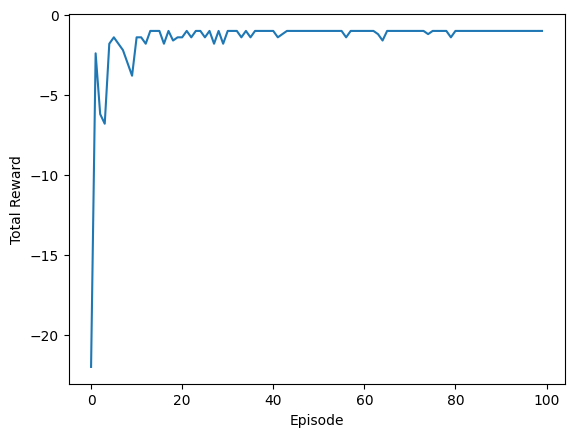

Training complete.
Results saved to asciiFig.txt and model saved to model_weights.json.


In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import os
from collections import deque
from math import sqrt
import json
import matplotlib.pyplot as plt

# #-------------------------------------
# フィールドサイズと匂い強度
FIELD_SIZE = 8  # フィールドのサイズ
SMELL_STRENGTH = 100  # 匂いの強度

# エージェントとゴールの初期位置
ANT_START = (0, 0)  # エージェントの初期位置
GOAL_POSITION = (FIELD_SIZE - 1, FIELD_SIZE - 4)  # ゴール位置

# #学習のモニタリング
rewards = []
# #-------------------------------------

# DQNのニューラルネットワーク定義
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# エージェントの定義
class Agent:
    def __init__(self, field_size, gamma=0.99, lr = 0.001, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        # print(lr)
        self.field_size = field_size
        self.state_size = field_size ** 2
        self.action_size = 4  # 上下左右の4方向
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.memory = deque(maxlen=2000)
        self.model = DQN(self.state_size, self.action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # ランダムアクション
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()  # Q値の最大を選択

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in batch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.model(next_state)).item() #Q学習の部分
            target_f = self.model(state).detach().clone()
            target_f[action] = target
            output = self.model(state)
            loss = self.criterion(output[action], target_f[action])
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # epsilonを減少させる

# 環境の定義
class Environment:
    def __init__(self, field_size, ant_start, goal_position, smell_strength):
        self.field_size = field_size
        self.ant_position = ant_start
        self.goal_position = goal_position
        self.smell_strength = 1/smell_strength #入力と逆にする

    def calculate_smell(self, position):
        """ゴールからの匂いの強さを計算"""
        distance = sqrt((position[0] - self.goal_position[0]) ** 2 + (position[1] - self.goal_position[1]) ** 2)
        return self.smell_strength / (1 + distance)
        # return (1 + distance)/self.smell_strength
    
    def reset(self):
        """環境をリセット"""
        self.ant_position = ANT_START
        state = np.zeros((self.field_size, self.field_size))
        state[self.ant_position] = 1  # エージェントの位置
        state[self.goal_position] = self.calculate_smell(self.goal_position)  # ゴール位置の匂い
        return state.flatten()

    def step(self, action):
        """アクションを受けて次の状態と報酬を計算"""
        x, y = self.ant_position
        if action == 0 and x > 0:  # 上
            x -= 1
        elif action == 1 and x < self.field_size - 1:  # 下
            x += 1
        elif action == 2 and y > 0:  # 左
            y -= 1
        elif action == 3 and y < self.field_size - 1:  # 右
            y += 1

        # 更新後の位置を保存
        new_position = (x, y)

        # 無効なアクションを防ぐ
        if new_position != self.ant_position:
            self.ant_position = new_position

        # 次の状態を作成
        state = np.zeros((self.field_size, self.field_size))
        state[self.ant_position] = 1
        state[self.goal_position] = self.calculate_smell(self.goal_position)

        # 報酬と終了判定
        reward = 1 if self.ant_position == self.goal_position else -0.1
        # ゴールに近づいた場合、追加の報酬
        if self.ant_position != self.goal_position:
            prev_distance = sqrt((x - self.goal_position[0])**2 + (y - self.goal_position[1])**2)
            new_distance = sqrt((self.ant_position[0] - self.goal_position[0])**2 + (self.ant_position[1] - self.goal_position[1])**2)
            reward += 0.1 if new_distance < prev_distance else -0.1
        done = self.ant_position == self.goal_position
        return state.flatten(), reward, done


# アスキー図を生成する関数
def render_ascii(env):
    """現在の環境状態をアスキー形式で表現（匂いの強さも表示）"""
    grid = [["-"] * env.field_size for _ in range(env.field_size)]
    ant_x, ant_y = env.ant_position
    goal_x, goal_y = env.goal_position
    grid[ant_x][ant_y] = "A"  # エージェントの位置
    grid[goal_x][goal_y] = "G"  # ゴール位置

    # 全セルの匂いを計算
    smell_map = np.zeros((env.field_size, env.field_size))
    for x in range(env.field_size):
        for y in range(env.field_size):
            smell_map[x, y] = env.calculate_smell((x, y))

    # ゴール以外の最大値と最小値を計算
    non_goal_smells = [
        smell_map[x, y]
        for x in range(env.field_size)
        for y in range(env.field_size)
        if (x, y) != (goal_x, goal_y)
    ]
    max_smell = max(non_goal_smells)
    min_smell = min(non_goal_smells)

    # アスキー文字の閾値を設定
    thresholds = {
        "@": max_smell * 0.8,
        "#": max_smell * 0.6,
        "+": max_smell * 0.4,
        ".": max_smell * 0.2,
        "-": min_smell,
    }

    # 匂いに基づいて文字を割り当て
    for x in range(env.field_size):
        for y in range(env.field_size):
            if (x, y) == (ant_x, ant_y) or (x, y) == (goal_x, goal_y):
                continue
            smell = smell_map[x, y]
            if smell >= thresholds["@"]:
                grid[x][y] = "@"
            elif smell >= thresholds["#"]:
                grid[x][y] = "#"
            elif smell >= thresholds["+"]:
                grid[x][y] = "+"
            elif smell >= thresholds["."]:
                grid[x][y] = "."
            else:
                grid[x][y] = "-"

    # フィールド全体を文字列として返す
    return "\n".join([" ".join(row) for row in grid])

# def log_path(env, episode, step, log_path="path_log.txt"):
#     """エージェントの移動軌跡をログとして保存"""
#     with open(log_path, "a") as f:
#         ant_x, ant_y = env.ant_position
#         goal_x, goal_y = env.goal_position
#         f.write(f"Episode {episode}, Step {step}: Ant at ({ant_x}, {ant_y}), Goal at ({goal_x}, {goal_y})\n")

def log_smell_correlation(env, action, log_file="smell_correlation.txt"):
    """アクション選択時の匂い強度をログ"""
    current_smell = env.calculate_smell(env.ant_position)
    next_position = env.ant_position
    if action == 0 and next_position[0] > 0:  # 上
        next_position = (next_position[0] - 1, next_position[1])
    elif action == 1 and next_position[0] < env.field_size - 1:  # 下
        next_position = (next_position[0] + 1, next_position[1])
    elif action == 2 and next_position[1] > 0:  # 左
        next_position = (next_position[0], next_position[1] - 1)
    elif action == 3 and next_position[1] < env.field_size - 1:  # 右
        next_position = (next_position[0], next_position[1] + 1)
    next_smell = env.calculate_smell(next_position)
    with open(log_file, "a") as f:
        f.write(f"Current smell: {current_smell}, Next smell: {next_smell}, Action: {action}\n")

# 学習ループ
def train_agent(episodes, batch_size, save_path="asciiFig.txt", model_save_path="model_weights.json", summary_path="episode_summary.txt"):
    # 環境とエージェントの初期化
    env = Environment(FIELD_SIZE, ANT_START, GOAL_POSITION, SMELL_STRENGTH)
    agent = Agent(FIELD_SIZE)

    # 既存のモデルがあれば読み込む
    if os.path.exists(model_save_path):
        print(f"Loading existing model from {model_save_path}...")
        
        # 学習前のモデルを保存
        temp_model = DQN(agent.state_size, agent.action_size)  # 修正: agent の属性を参照
        load_model_from_json(temp_model, model_save_path)
        
        # temp_model の最初の層の重みをプリント　ロードチェック用
        # print("Weights of the model before training (fc1):")
        # print(temp_model.fc1.weight.data)

        # 現在のモデルにロード
        load_model_from_json(agent.model, model_save_path)

        agent.epsilon = load_model_from_json(agent.model, model_save_path)
        load_memory(agent, "memory.json")

    else:
        print("No existing model found. Starting with a new model.")

    # アスキー図の保存用ファイルを開く
    with open(save_path, "w") as ascii_file, open(summary_path, "w") as summary_file:
        summary_file.write("Episode, Total Reward, Steps\n")  # サマリーのヘッダー

        for episode in range(1, episodes + 1):
            state = env.reset()
            done = False
            total_reward = 0
            step_count = 0

            ascii_file.write(f"Episode {episode}, Step 1\n")
            ascii_file.write(render_ascii(env) + "\n\n")  # 初期状態の出力

            agent_path = []  # エージェントの経路を記録
            smell_correlation_data = []  # 匂い強度と位置の関連データを記録

            while not done:
                # アクションを選択
                action = agent.act(state)
                
                # 環境を更新
                next_state, reward, done = env.step(action)
                total_reward += reward
                step_count += 1

                # 経験を記憶し、学習
                agent.remember(state, action, reward, next_state, done)
                agent.replay(batch_size)
                state = next_state

                # ステップごとのアスキー図を保存（終了状態まで）
                if not done:
                    ascii_file.write(f"Episode {episode}, Step {step_count + 1}\n")
                    ascii_file.write(render_ascii(env) + "\n\n")

                agent_path.append(env.ant_position)  # エージェントの現在位置を経路に追加
                smell_correlation_data.append((env.ant_position, env.calculate_smell(env.ant_position)))  # 匂いデータを記録


            # エピソード終了時の情報を記録
            ascii_file.write(f"Episode {episode} finished after {step_count} steps\n\n")
            summary_file.write(f"{episode}, {total_reward}, {step_count}\n")  # サマリーに書き出し

            print(f"Episode {episode}: Total reward: {total_reward}, Steps: {step_count}")

            # モデルをエピソードごとに保存
            torch.save(agent.model.state_dict(), model_save_path)

            # 学習ループ内でモデル保存
            save_model_to_json(agent.model, model_save_path, agent.epsilon)
            save_memory(agent, "memory.json")
        
            rewards.append(total_reward)  # 各エピソードの報酬を記録

            # エピソード終了時にデータをログ
            # log_path(env, episode, step_count)
            # log_smell_correlation(episode, smell_correlation_data)

        # 報酬の推移をプロット
        plt.plot(rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

        # 学習終了後にポリシーを可視化
        # print("Visualizing policy...")
        # visualize_policy(agent, env)

# def visualize_policy(env, agent):
#     """各セルにおけるエージェントの方策を可視化"""
#     policy_grid = [["-"] * env.field_size for _ in range(env.field_size)]
#     for x in range(env.field_size):
#         for y in range(env.field_size):
#             position = np.zeros((env.field_size, env.field_size)).flatten()
#             position[x * env.field_size + y] = 1
#             action = agent.act(position)
#             policy_grid[x][y] = ["↑", "↓", "←", "→"][action]
#     return "\n".join([" ".join(row) for row in policy_grid])


# モデル保存 (テキスト形式)
def save_model_to_json(model, file_path, epsilon):
    # モデルの状態辞書を取得
    state_dict = model.state_dict()

    # パラメータをJSONに変換
    model_dict = {}
    for param_tensor in state_dict:
        # パラメータのテンソルをリストに変換
        model_dict[param_tensor] = state_dict[param_tensor].cpu().numpy().tolist()

    # epsilonを保存
    model_dict["epsilon"] = epsilon
    
    # JSONファイルに保存
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(model_dict, f, indent=4)

    # print(f"Model saved to {file_path}.")


# モデル読み込み (テキスト形式)
def load_model_from_json(model, file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        model_dict = json.load(f)

    # モデルのstate_dictにパラメータをロード
    state_dict = {k: torch.tensor(v) for k, v in model_dict.items() if k != "epsilon"}
    model.load_state_dict(state_dict)


    # モデルにパラメータをロード
    model.load_state_dict(state_dict)
    print(f"Model loaded from {file_path}.")

    # 最初の層の重みをプリント　ロードチェック用
    # print("Load Initial weights of fc1 (first layer):")
    # print(model.fc1.weight.data)

    # epsilonを復元
    epsilon = model_dict.get("epsilon", 1.0)
    print(f"Model loaded from {file_path}. Epsilon: {epsilon}")
    return epsilon


# メモリの保存
def save_memory(agent, memory_file_path):
    # メモリの内容をリストに変換
    memory_list = [
        [item.tolist() if isinstance(item, np.ndarray) else item for item in experience]
        for experience in agent.memory
    ]
    
    # JSON に保存
    with open(memory_file_path, "w", encoding="utf-8") as f:
        json.dump(memory_list, f, indent=4)  # インデント追加
    # print(f"Memory saved to {memory_file_path}.")

    # コメント風のフィールドを追加
    memory_with_comment = [{"_comment": "Memory format: [state, action, reward, next_state, done]"}]
    memory_with_comment.extend(memory_list)
    
    with open(memory_file_path, "w", encoding="utf-8") as f:
        json.dump(memory_with_comment, f, indent=4)
    # print(f"Memory saved to {memory_file_path}.")


# メモリの読み込み
def load_memory(agent, memory_file_path):
    if os.path.exists(memory_file_path):
        with open(memory_file_path, "r", encoding="utf-8") as f:
            memory_list = json.load(f)

        # コメントを除外
        memory_list = [item for item in memory_list if not isinstance(item, dict)]

        # リストを再度 `deque` に変換し、必要に応じて numpy.ndarray に戻す
        agent.memory = deque(
            [
                [np.array(item) if isinstance(item, list) and isinstance(item[0], float) else item for item in experience]
                for experience in memory_list
            ],
            maxlen=2000
        )
        print(f"Memory loaded from {memory_file_path}.")
    else:
        print("No memory file found. Starting with an empty memory.")


# メイン処理
def main():
    # 設定
    episodes = 100  # 学習エピソード数
    batch_size = 32  # ミニバッチサイズ
    save_path = "asciiFig.txt"  # 学習過程の保存先
    model_save_path = "model_weights.json"  # 学習モデルの保存先

    # 環境とエージェントの初期化
    print("Initializing environment and agent...")
    env = Environment(FIELD_SIZE, ANT_START, GOAL_POSITION, SMELL_STRENGTH)
    agent = Agent(FIELD_SIZE)

    # 学習ループの実行
    print(f"Training for {episodes} episodes...")
    train_agent(episodes, batch_size, save_path, model_save_path)

    print("Training complete.")
    print(f"Results saved to {save_path} and model saved to {model_save_path}.")

    # print("Visualizing policy...")
    # visualize_policy(agent, env)
    # print("Policy visualization complete.")

if __name__ == "__main__":
    main()
    

結果ビューアー

In [ ]:
import tkinter as tk
from tkinter import ttk

def load_ascii_file(file_path):
    """asciiFig.txtを読み込んでデータを辞書に変換する関数"""
    data = {}
    current_episode = None
    current_step = None
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip()
            if line.startswith("Episode") and "Step" in line:
                parts = line.replace(",", "").split()
                current_episode = int(parts[1])  # エピソード番号
                current_step = int(parts[3])  # ステップ番号
                if current_episode not in data:
                    data[current_episode] = {}
                data[current_episode][current_step] = []
            elif line.startswith("Episode") and "finished" in line:
                # 終了行をスキップ
                continue
            elif current_episode is not None and current_step is not None and line != "":
                data[current_episode][current_step].append(line)
    return data


class EpisodeViewerApp(tk.Tk):
    def __init__(self, data):
        super().__init__()
        self.title("Episode Viewer")
        self.geometry("400x300")
        
        self.data = data
        self.current_episode = 1
        self.current_step = 1

        # エピソード選択
        tk.Label(self, text="Episode:").grid(row=0, column=0, padx=5, pady=5, sticky="w")
        self.episode_var = tk.IntVar(value=1)
        self.episode_selector = ttk.Spinbox(self, from_=1, to=len(data), textvariable=self.episode_var, command=self.update_steps)
        self.episode_selector.grid(row=0, column=1, padx=5, pady=5)

        # ステップ選択（シークバー）
        tk.Label(self, text="Step:").grid(row=1, column=0, padx=5, pady=5, sticky="w")
        self.step_var = tk.IntVar(value=1)
        self.step_slider = ttk.Scale(self, from_=1, to=1, orient="horizontal", variable=self.step_var, command=self.update_display)
        self.step_slider.grid(row=1, column=1, padx=5, pady=5, sticky="ew")

        # 図の表示エリア
        self.display_area = tk.Text(self, wrap="none", width=30, height=10)
        self.display_area.grid(row=2, column=0, columnspan=2, padx=5, pady=5)

        # 更新ボタン
        self.update_button = ttk.Button(self, text="Update", command=self.update_display)
        self.update_button.grid(row=3, column=0, columnspan=2, pady=5)

        # 初期表示
        self.update_steps()

    def update_steps(self):
        """エピソード変更時にステップ数を更新"""
        episode = self.episode_var.get()
        if episode in self.data:
            max_steps = len(self.data[episode])
            self.step_slider.config(to=max_steps)
            self.step_var.set(1)
            self.update_display()

    def update_display(self, *_):
        """選択されたエピソードとステップに基づいて図を更新"""
        episode = self.episode_var.get()
        step = int(self.step_var.get())
        if episode in self.data and step in self.data[episode]:
            self.display_area.delete("1.0", tk.END)
            diagram = "\n".join(self.data[episode][step])
            self.display_area.insert("1.0", f"Episode {episode}, Step {step}\n\n{diagram}")
        else:
            self.display_area.delete("1.0", tk.END)
            self.display_area.insert("1.0", "No data available for this step.")

# メイン処理
if __name__ == "__main__":
    # ファイルを読み込む
    file_path = "asciiFig.txt"
    # file_path = "asciiFig_X.txt"
    data = load_ascii_file(file_path)

    # アプリケーションを起動
    app = EpisodeViewerApp(data)
    app.mainloop()
